# Agent-based model

This is a model of embryonic neocortex population, using an agent-based framework.
This means that we create cells, on we sample a Tc from the age-related distribution.
At the end of cell cycle, the fate decision for the daughters are.

The model starts at E48, where we have the first data.

Data will be of different types :

Tc:
- Population level estimation
- Cell level estimation

Differentiation:
- Cell level estimation

Number of progenitors:
- Ki67 ratio in GZ
- Ratio of Tbr2+ and Sox2+

Number of cells:
- Relative volume from Histo + MRI
- Density of cells

We will have to discuss quality of the data

In [1]:
# imports
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
from numpy.random import choice
from scipy.interpolate import splev, splrep, interp1d
from gpn2 import GrowingPlanarNetwork

In [2]:
nop = lambda *a, **k: None

## Loading data

In [3]:
# Volume MRI + Histo
volumes = pd.read_csv('data/VolumeArea17.csv')

## Preprocessing data

In [4]:
# from PolynomRegression
Tc_ = lambda time: 277.36424309532794 - 0.023973977538587 * time - 0.761568634472077 * time**2 + \
    0.025594287611410 * time**3 - 0.000307496975562 * time**4 + 0.000001264230759 * time**5
print("Polynom Reg", Tc_(48), Tc_(65), Tc_(78))

Polynom Reg 41.8919627067869 64.8715873071742 55.96794765296363


In [5]:
# what we do is to average some ages
volumes = volumes.append(volumes.loc[volumes.Age.isin([70, 72])].mean(), ignore_index=True)
volumes = volumes.append(volumes.loc[volumes.Age.isin([78, 79])].mean(), ignore_index=True)
volumes = volumes.append(volumes.loc[volumes.Age.isin([84, 86])].mean(), ignore_index=True)
volumes = volumes.loc[~volumes.Age.isin([70, 72, 78, 79, 84, 86])]

In [6]:
col = volumes.loc[:, ["Ratio_Histo_VZ", "Ratio_MRI_VZ"]]
volumes['Ratio_VZ'] = col.mean(axis=1)
col = volumes.loc[:, ["Ratio_Histo_ISVZ", "Ratio_MRI_ISVZ"]]
volumes['Ratio_ISVZ'] = col.mean(axis=1) * volumes.loc[0, "Histo_ISVZ"] / volumes.loc[0, "Histo_VZ"]
col = volumes.loc[:, ["Ratio_Histo_OSVZ", "Ratio_MRI_OSVZ"]]
volumes['Ratio_OSVZ'] = col.mean(axis=1) * volumes.loc[0, "Histo_OSVZ"] / volumes.loc[0, "Histo_VZ"]

In [7]:
volumes.loc[:, ["AverageDensityVZ", "AverageDensityISVZ", "AverageDensityOSVZ"]] /= \
    volumes.loc[0, "AverageDensityVZ"]
volumes["total_cell_number"] = volumes["AverageDensityVZ"] * volumes["Ratio_VZ"] + \
                               volumes["AverageDensityISVZ"] * volumes["Ratio_ISVZ"] + \
                               volumes["AverageDensityOSVZ"] * volumes["Ratio_OSVZ"]
volumes.head()

,Age,Histo_VZ,Histo_ISVZ,Histo_OSVZ,Histo_SP,Histo_CP,MRI_VZ,MRI_ISVZ,MRI_OSVZ,MRI_SP,...,RelativeDensityVZ,RelativeDensityISVZ,RelativeDensityOSVZ,AverageDensityVZ,AverageDensityISVZ,AverageDensityOSVZ,Ratio_VZ,Ratio_ISVZ,Ratio_OSVZ,total_cell_number
0,49.0,0.264,0.118,0.012,NaN,0.056,0.527,0.236,0.024,NaN,...,1.000,1.00,1.000,1.000000,0.441331,0.044134,1.0000,0.446970,0.045455,1.199268
1,63.0,0.716,0.428,3.666,NaN,2.284,1.161,0.698,5.871,4.807,...,0.820,1.34,10.540,0.821235,0.592874,0.465094,2.4590,1.474330,12.733250,8.815673
8,94.0,0.910,0.767,6.152,NaN,15.344,NaN,NaN,NaN,NaN,...,0.230,0.28,2.800,0.234263,0.121405,0.123754,3.4520,2.909773,23.732864,4.098968
9,71.0,0.615,0.498,5.095,NaN,3.962,1.880,1.486,15.337,17.782,...,0.545,0.93,7.330,0.542118,0.409147,0.323570,2.9495,2.352625,24.617727,10.527115
10,78.5,0.374,0.342,4.686,NaN,5.366,1.030,0.957,12.835,17.322,...,0.480,0.88,5.495,0.477197,0.387065,0.242614,1.6895,1.556795,21.415750,6.604573


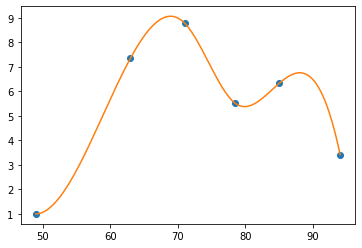

In [8]:
# complicated stuff to sort the list
sorted_number_cells = tuple(zip(*tuple(sorted(list(zip(volumes["Age"],
                                                       volumes["total_cell_number"] /
                                                       volumes.loc[0, "total_cell_number"])),
                                              key=lambda x: x[0]))))
spl = splrep(*sorted_number_cells)
x2 = np.linspace(49, 94, 200)
y2 = splev(x2, spl)
plt.plot(*sorted_number_cells, 'o', x2, y2)
plt.show()

In [9]:
def callback():
    plt.plot(*sorted_number_cells, 'o', x2, y2)

In [10]:
# Cell fate will be the first parameter to tune

In [11]:
# Definition of the var of the model
# We start with 100 cells for homogeneity
START_POPULATION_SQRT = 10
START_TIME = 49
END_TIME = 94
# We arbitrarily set variance of Tc at 12.5^2
# 95 % seems to be into 50, so sigma = 50 / 4 = 12.5
SIG_TC = 12.5

<Figure size 1440x1440 with 0 Axes>

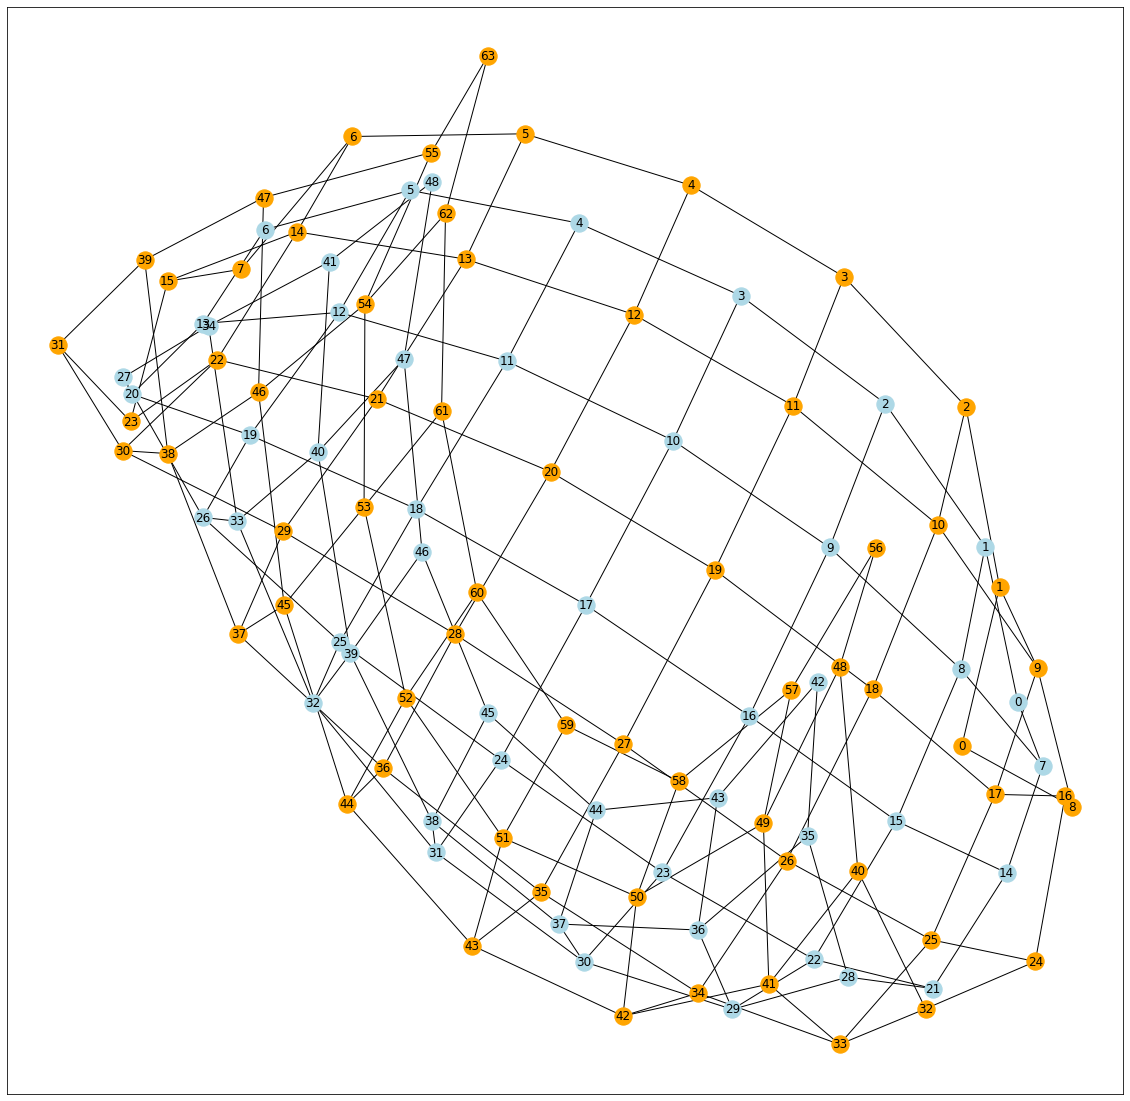

In [12]:
gpn = GrowingPlanarNetwork()
gpn.init_square(8)
plt.figure(figsize=(20, 20))
gpn.show_all(figsize=(20, 20))

In [13]:
"""
k_n = k_ref / (0.9 + p / 10)  # so as effective k stay the same even though p changes
k_p = 0.9 * k_n
"""
pass
# This is the formula to adapt k (1/Tc) according to progenitor

In [14]:
from enum import Enum

class CellTypeBasic(Enum):
    Cycling = 0
    PostMitotic = 1
    Dead = 2
    
class CellTypeClassic(Enum):
    RG = 0
    IP = 1
    PostMitotic = 2
    Dead = 3
    
class Action(Enum):
    NoOp = 0
    Divide = 1
    Die = 2
    DiffNeuron = 3
    DiffIP = 4
    Migrate = 5

In [15]:
class Submodels:
    """
    This class implements all parameters that are required, also under the callback form
    """
    def __init__(self, Tc_func, diff_func):
        self.Tc = Tc_func
        self.diff = diff_func

In [16]:
def tc_func_1(time_, type_):
    return max(np.random.normal(Tc_(time_), SIG_TC), 10) / 24. # because we are in Days

timesteps = np.array([49, 61, 72, 83, 95])
diff_values = np.array([0.73, 0.63, 0.47, 0.45, 0.45])
lin_diff = interp1d(timesteps, diff_values)

def diff_func_1(time_, type_):
    val = lin_diff(time_)
    return choice([CellTypeBasic.Cycling, CellTypeBasic.PostMitotic], 1, p=[val, 1-val])[0]

diff_func_1(49, None)

<CellTypeBasic.Cycling: 0>

In [17]:
submodel1 = Submodels(tc_func_1, diff_func_1)

In [18]:
def cell_fate(T):
    return 0.5 # return choice(["cycling", "postmitotic"], 1, p=[0.5, 0.5])

# Definition of the class
class Brain:
    
    ##################
    # INITIALISATION #
    ##################
    
    def __init__(self,
                 start_population=START_POPULATION_SQRT,
                 start_time=START_TIME,
                 end_time=END_TIME,
                 time_step=1,
                 sig_tc=SIG_TC,
                 submodel=None,
                 verbose=False,
                ):
        self.verbose = verbose
        self.start_population = start_population
        self.start_time = start_time
        self.end_time = end_time
        self.time_step = time_step
        self.sig_tc = SIG_TC
        self.submodel = submodel
        self.gpn = GrowingPlanarNetwork()
        self.initiate_population()
        self.init_stats()
        self.reference_model_callback = lambda: None
        
    def debug(self, x):
        if self.verbose:
            print(x)
        
    def set_reference_model(self, callback):
        self.reference_model_callback = callback
        
    def initiate_population(self):
        self.gpn.init_square(self.start_population)
        self.population = {i: Cell(self.start_time, start=True, brain=self, index=i, submodel=self.submodel)
                           for i in self.gpn.G.nodes}
        self.old_population = dict()
        
    ##################
    #### CLOCKING ####
    ##################

    def run(self):
        for T in np.arange(self.start_time, self.end_time, self.time_step):
            self._tick(T, self.time_step)

        return df_pop
    
    def _tick(self, absolute_time, relative_time):
        self.debug(f"Ticking abs : {absolute_time}, step : {relative_time}")
        self._sanity_check()
        
        # take care of cells
        for C in list(self.population.values()):
            neighbours = self.get_neighbours(C)
            action = C.tick(absolute_time, relative_time, neighbours)
            self.run_action(action, C, absolute_time)
                    
        # monitor
        stats = dict(progenitor_pop_size=len(self.population),
                     whole_pop_size=len(self.old_population) + len(self.population),
                     time=absolute_time,
                    )
        
        self.add_stat_time(absolute_time, stats)
    
    def _sanity_check(self):
        if len(self.population) > 1e5:
            raise RuntimeError("Model stops when population increases above 1E5")
            
    #################
    ###  ACTIONS  ###
    #################
    
    def run_action(self, action, cell, T):
        mapping = {
            Action.Divide: self.divide,
            Action.Die: self.remove_cell,
            Action.DiffNeuron: self.remove_cell,
            Action.DiffIP: nop,
            Action.NoOp: nop,
        }
        
        mapping[action](cell, T)
        
    def divide(self, cell, T):
        """
        Warning : the id of one daughter is the same as for the mother
        We will have to modify the gpn code to overcome that
        """
        new_cell = cell.generate_daughter_cell(T)
        self.debug("Duplicating " + str(cell.index))
        new_index = self.gpn.duplicate_node(cell.index)
        new_cell.index = new_index
        self.debug("New index " + str(new_cell.index))
        self.population[new_index] = new_cell
        self.population[cell.index] = cell.generate_daughter_cell(T)
        self.population[cell.index].index = cell.index
    
    def remove_cell(self, cell, T):
        self.debug("Removing " + str(cell.index))
        self.gpn.remove_node(cell.index)
        self.old_population[cell.index] = cell
        del self.population[cell.index]
            
    #################
    ###  HELPERS  ###
    #################
            
    def get_neighbours(self, cell):
        ngbs = self.gpn.ngb(cell.index)
        return [self.population[i] for i in ngbs]
    
    ##################
    ### STATISTICS ###
    ##################
    
    def init_stats(self):
        self.stats = pd.DataFrame({"progenitor_pop_size": [self.start_population],
                               "whole_pop_size": [self.start_population],
                               "time": [self.start_time]},
                               index=[self.start_time]
                             )
    
    def add_stat_time(self, abs_time, stats: dict):
        self.stats.append(pd.Series(stats, name=abs_time))
    
    def show_end_curve(self, df_pop):
        xspace = range(int(self.start_time), int(self.end_time) + 1)
        plt.figure(figsize=(18, 12))
        
        plt.subplot(2, 2, 1)
        plt.title("Number or progenitors")
        plt.plot(xspace, df_pop["cycling_size"] / 100)
        self.reference_model_callback() # plt.plot(*sorted_number_cells, 'o', x2, y2)

        plt.subplot(2, 2, 2)
        plt.title("Rate of differentation")
        y_diff = [self.cell_fate_func(x) for x in xspace]
        plt.plot(xspace, y_diff)
        
        plt.subplot(2, 2, 3)
        plt.title("Number or total cells")
        plt.plot(xspace, df_pop["total_size"] / 100)
        
        plt.subplot(2, 2, 4)
        plt.title("Time of cell cycle")
        y_Tc = [self.Tc_func(x) for x in xspace]
        plt.ylim(0, max(100, np.max(y_Tc)))
        plt.plot(xspace, y_Tc)
        plt.show()  
      
    
    
class Cell:
    def __init__(self, T, start=False, brain=None, index=None, submodel=None):
        # references
        self.brain = brain
        self.submodel = submodel
        
        # cell data
        self.appear_time = T
        self.division_time = np.Inf
        self.index = index
        
        if start:
            self._type = CellTypeBasic.Cycling
        else:
            self._type = self.submodel.diff(T, None)
        
        if self._type == CellTypeBasic.Cycling:
            self.cycle(T, start)
            
    def tick(self, abs_time, rel_time, neighbours=None):
        if self._type != CellTypeBasic.Cycling:
            return Action.DiffNeuron
        
        elif abs_time > self.division_time:
            return Action.Divide
        
        else:
            return Action.NoOp
            
    def cycle(self, T, start=False):
        self.Tc = self.submodel.Tc(T, None)
        if start:
            self.eff_Tc = np.random.uniform(0, self.Tc)
        else:
            self.eff_Tc = self.Tc
        self.division_time = T + self.eff_Tc
    
    def __gt__(self, C):
        return self.division_time > C.division_time
    
    def generate_daughter_cell(self, T):
        return Cell(T, start=False, brain=self.brain, submodel=self.submodel)

GG2
GG3
creating edge for 3 6
(3, 6) [(9, 3), (9, 6)]
GG2
GG2
GG3
GG3
GG3
GG3
GG3
GG3
(1, 14) {'dual': (-1, 10, 0)}
(1, 12) {'dual': (5, 10, 0)}
(1, 0) {'dual': (-1, 5, 0)}
(0, 11) {'dual': (0, -1, 1)}
(0, 3) {'dual': (5, 0, 0)}
(2, 10) {'dual': (6, -1, 1)}
(2, 4) {'dual': (1, 8, 0)}
(2, 13) {'dual': (6, 8, 0)}
(2, 14) {'dual': (1, -1, 0)}
(3, 11) {'dual': (4, 0, 0)}
(3, 12) {'dual': (5, 11, 0)}
(3, 7) {'dual': (11, 4, 0)}
(4, 12) {'dual': (2, 1, 0)}
(4, 13) {'dual': (8, 9, 0)}
(4, 15) {'dual': (9, 2, 0)}
(5, 10) {'dual': (-1, 6, 0)}
(5, 13) {'dual': (3, 6, 0)}
(5, 8) {'dual': (-1, 3, 1)}
(6, 11) {'dual': (-1, 4, 2)}
(6, 7) {'dual': (4, -1, 3)}
(7, 15) {'dual': (2, -1, 0)}
(7, 12) {'dual': (2, 11, 0)}
(8, 16) {'dual': (-1, 3, 2)}
(12, 14) {'dual': (10, 1, 0)}
(13, 16) {'dual': (3, 9, 0)}
(15, 16) {'dual': (9, -1, 0)}
1 {'ngb': [0, 12, 14]}
0 {'ngb': [11, 3, 1]}
2 {'ngb': [14, 4, 13, 10]}
3 {'ngb': [7, 12, 0, 11]}
4 {'ngb': [15, 13, 2, 12]}
5 {'ngb': [8, 10, 13]}
6 {'ngb': [7, 11]}
7 {'

17

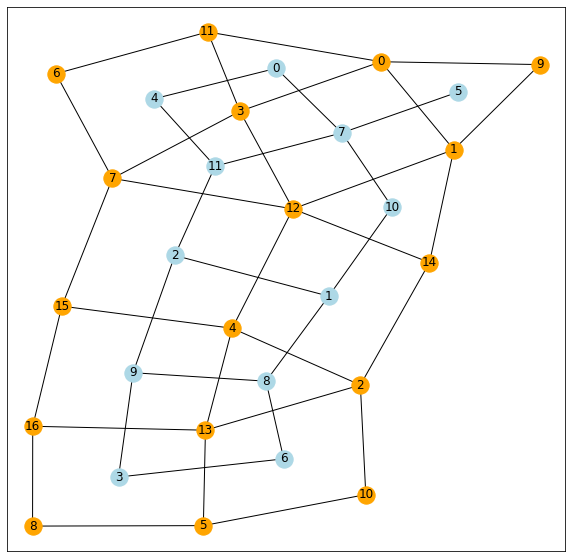

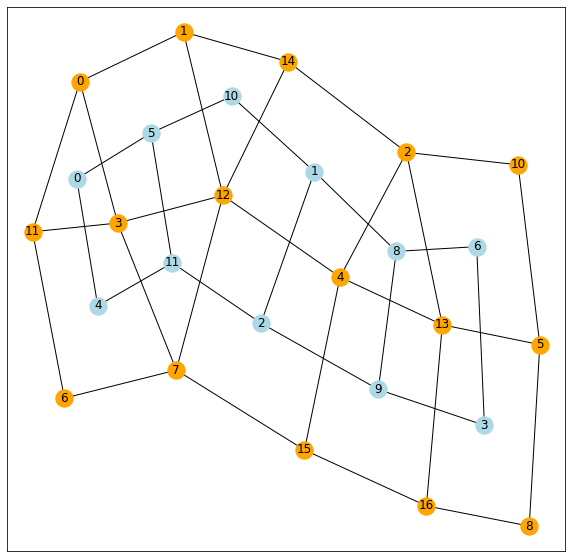

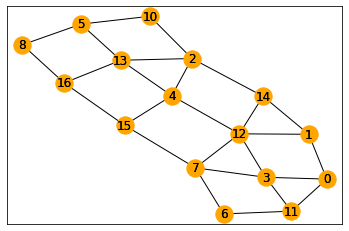

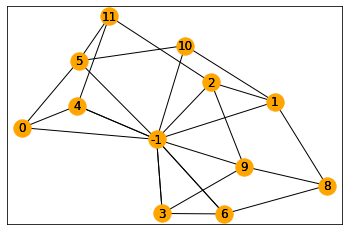

In [19]:
random.seed(0)
np.random.seed(0)
gpn = GrowingPlanarNetwork()
gpn.init_square(3)
gpn.check_all()
gpn.duplicate_node(6)
gpn.check_all()
gpn.duplicate_node(7)
gpn.check_all()
gpn.remove_node(9)
gpn.check_all()
gpn.remove_node(10)
gpn.check_all()
gpn.duplicate_node(0)
gpn.check_all()
gpn.duplicate_node(2)
gpn.check_all()
gpn.duplicate_node(3)
gpn.check_all()
gpn.duplicate_node(4)
gpn.check_all()
gpn.duplicate_node(5)
gpn.check_all()
gpn.duplicate_node(1)
gpn.check_all()
gpn.duplicate_node(7)
gpn.check_all()
gpn.duplicate_node(8)
gpn.check_all()
gpn.show_all()
gpn.remove_node(9)
gpn.check_all()
gpn.show_all()
gpn.debug_all()
gpn.remove_node(7)

# gpn.show_all()
# gpn.debug_all()
gpn.check_all()
gpn.duplicate_node(6)

(1, 14) {'dual': (-1, 10, 0)}
(1, 12) {'dual': (5, 10, 0)}
(1, 0) {'dual': (-1, 5, 0)}
(0, 11) {'dual': (0, -1, 1)}
(0, 3) {'dual': (5, 0, 0)}
(2, 10) {'dual': (6, -1, 1)}
(2, 4) {'dual': (1, 8, 0)}
(2, 13) {'dual': (6, 8, 0)}
(2, 14) {'dual': (1, -1, 0)}
(3, 11) {'dual': (4, 0, 0)}
(3, 12) {'dual': (11, 5, 1)}
(3, 17) {'dual': (11, 4, 0)}
(4, 12) {'dual': (2, 1, 0)}
(4, 13) {'dual': (8, 9, 0)}
(4, 15) {'dual': (9, 2, 0)}
(5, 10) {'dual': (-1, 6, 0)}
(5, 13) {'dual': (3, 6, 0)}
(5, 8) {'dual': (-1, 3, 1)}
(6, 11) {'dual': (4, -1, 2)}
(6, 17) {'dual': (4, -1, 1)}
(8, 16) {'dual': (-1, 3, 2)}
(12, 14) {'dual': (10, 1, 0)}
(12, 15) {'dual': (11, 2, 0)}
(13, 16) {'dual': (3, 9, 0)}
(15, 16) {'dual': (9, -1, 0)}
(15, 17) {'dual': (-1, 11, 0)}
1 {'ngb': [0, 12, 14]}
0 {'ngb': [11, 3, 1]}
2 {'ngb': [14, 4, 13, 10]}
3 {'ngb': [12, 0, 11, 17]}
4 {'ngb': [15, 13, 2, 12]}
5 {'ngb': [8, 10, 13]}
6 {'ngb': [11, 17]}
8 {'ngb': [5, 16]}
10 {'ngb': [5, 2]}
11 {'ngb': [0, 6, 3]}
12 {'ngb': [14, 1, 3, 1

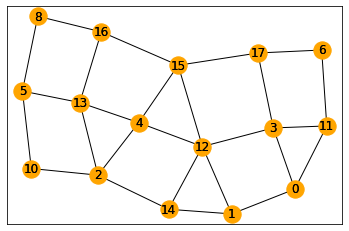

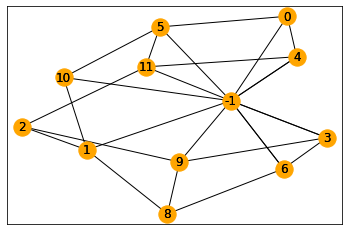

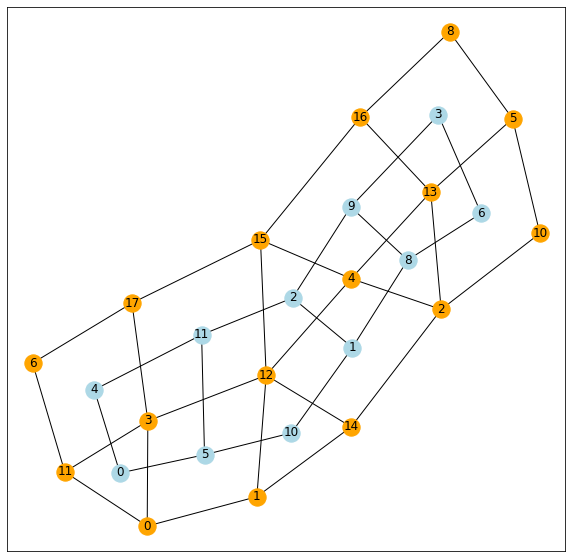

In [20]:
gpn.debug_all()
gpn.show_all()

In [21]:
random.seed(0)
np.random.seed(0)
bb = Brain(time_step=0.5, submodel=submodel1, verbose=True, start_population=3)

In [22]:
bb.run()

Ticking abs : 49.0, step : 0.5
Ticking abs : 49.5, step : 0.5
Duplicating 6
GG2
New index 9
Duplicating 7
GG3
New index 10
Ticking abs : 50.0, step : 0.5
Removing 9
creating edge for 3 6
(3, 6) [(9, 3), (9, 6)]
Removing 10
Ticking abs : 50.5, step : 0.5
Duplicating 0
GG2
New index 9
Duplicating 2
GG2
New index 10
Duplicating 3
GG3
New index 11
Duplicating 4
GG3
New index 12
Duplicating 5
GG3
New index 13
Ticking abs : 51.0, step : 0.5
Duplicating 1
GG3
New index 14
Duplicating 7
GG3
New index 15
Duplicating 8
GG3
New index 16
Removing 9
Ticking abs : 51.5, step : 0.5
Removing 7
creating edge for 6 15
(6, 15) [(7, 6), (7, 15)]
Ticking abs : 52.0, step : 0.5
Duplicating 6
GG3
New index 17
Ticking abs : 52.5, step : 0.5
Duplicating 2
GG3
New index 18
Duplicating 3
GG3
New index 19
Duplicating 5
GG3
New index 20
Duplicating 11
GG3
New index 21
Duplicating 12
GG3
New index 22
Duplicating 13
GG3
New index 23
Duplicating 15
GG3
New index 24
Ticking abs : 53.0, step : 0.5
Duplicating 1
GG3
New

Ticking abs : 64.0, step : 0.5
Duplicating 2
GG3
New index 160
Duplicating 37
GG3
New index 161
Duplicating 57
GG3
New index 162
Duplicating 73
GG3
New index 163
Removing 74
creating edge for 125 154
(125, 154) [(74, 125), (74, 154)]
Removing 87
Duplicating 97
GG3
New index 164
Duplicating 109
GG3
New index 165
Duplicating 118
GG3
New index 166
Duplicating 125
GG3
New index 167
Removing 151
Removing 155
Removing 156
Ticking abs : 64.5, step : 0.5
Removing 2
Duplicating 15
GG3
New index 168
Removing 37
Removing 73
creating edge for 154 140
(154, 140) [(73, 154), (73, 140)]
Duplicating 90
GG3
New index 169
Removing 97
creating edge for 164 125
(164, 125) [(97, 164), (97, 125)]
Duplicating 111
GG3
New index 170
Duplicating 117
GG3
New index 171
Duplicating 119
GG3
New index 172
Duplicating 121
GG3
New index 173
Duplicating 123
GG3
New index 174
Duplicating 127
GG3
New index 175
Duplicating 131
GG3
New index 176
Duplicating 134
GG3
New index 177
Removing 162
Removing 163
Removing 164
creat

AssertionError: error for degree 4, node 221, ingb 28

In [25]:
bb.gpn.G.degree(221)

4

(15, 190) {'dual': (235, 93, 0)}
(15, 224) {'dual': (209, 238, 0)}
(15, 193) {'dual': (209, 235, 0)}
(15, 95) {'dual': (238, 93, 0)}
(33, 153) {'dual': (85, 159, 0)}
(33, 212) {'dual': (194, 159, 0)}
(33, 234) {'dual': (143, 247, 0)}
(33, 174) {'dual': (194, 247, 0)}
(33, 200) {'dual': (85, 143, 0)}
(61, 186) {'dual': (56, 3, 0)}
(61, 175) {'dual': (124, 56, 0)}
(61, 212) {'dual': (3, 194, 0)}
(61, 123) {'dual': (186, 124, 0)}
(61, 174) {'dual': (194, 186, 0)}
(68, 131) {'dual': (201, 183, 0)}
(68, 222) {'dual': (110, 237, 1)}
(68, 144) {'dual': (61, 183, 0)}
(68, 90) {'dual': (61, 237, 0)}
(68, 230) {'dual': (201, 26, 0)}
(68, 125) {'dual': (110, 26, 0)}
(90, 126) {'dual': (44, 211, 0)}
(90, 222) {'dual': (211, 237, 0)}
(90, 225) {'dual': (44, 61, 0)}
(95, 144) {'dual': (93, 215, 0)}
(95, 226) {'dual': (174, 215, 0)}
(95, 188) {'dual': (174, 238, 0)}
(104, 184) {'dual': (36, 103, 0)}
(104, 201) {'dual': (23, 103, 0)}
(104, 105) {'dual': (36, 23, 0)}
(105, 201) {'dual': (23, 166, 0)}
(

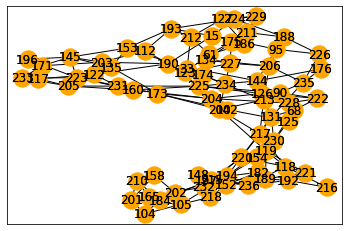

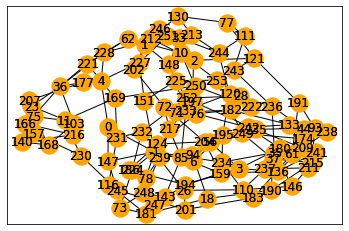

In [26]:
bb.gpn.debug_all()

In [27]:
import networkx as nx

def show(G, k=5, iterations=1000):
        pos = nx.spring_layout(G, k=k, iterations=iterations)
        nx.draw_networkx(G, pos, node_color="orange")
        # nx.draw_networkx(G, pos, nodelist=self.get_non_border_nodes(), node_color="lightblue")
        nx.draw_networkx_labels(G, pos)

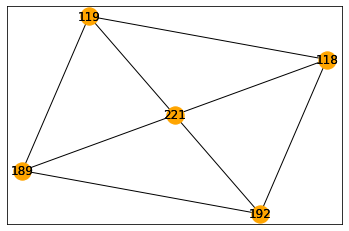

In [30]:
ego = nx.ego_graph(bb.gpn.G, 221)
show(ego)

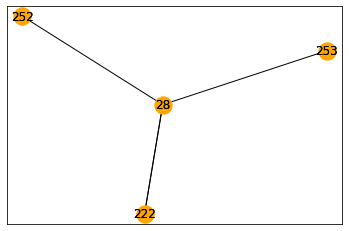

In [31]:
ego = nx.ego_graph(bb.gpn.D, 28)
show(ego)

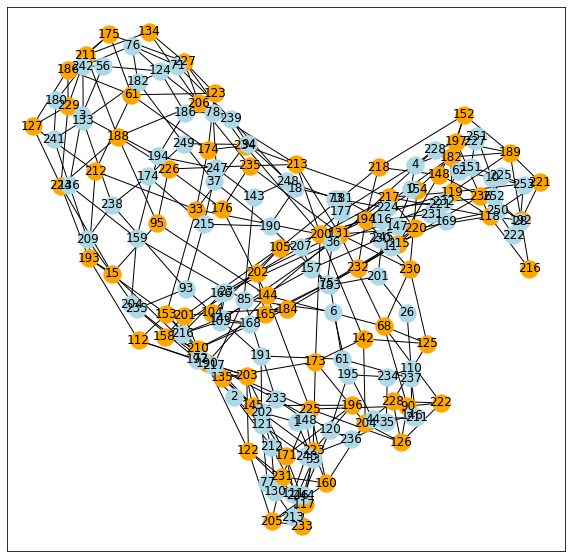

In [24]:
bb.gpn.show_all()

In [ ]:
(125, 154) in bb.gpn.G.edges

In [ ]:
bb.gpn.G.nodes[125]["ngb"], bb.gpn.G.nodes[154]["ngb"], bb.gpn.G.nodes[74]["ngb"]

In [ ]:
raise

In [ ]:
b = Brain()
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
timesteps = np.array([49, 61, 72, 83, 95])
diff_values = np.array([0.73, 0.63, 0.47, 0.45, 0.45])
lin_diff = interp1d(timesteps, diff_values)
b = Brain(cell_fate_func=lin_diff)
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
timesteps = np.array([49, 61, 72, 83, 95])
diff_values = np.array([0.73, 0.63, 0.47, 0.45, 0.45])
lin_diff = interp1d(timesteps, diff_values)
b = Brain(cell_fate_func=lin_diff, Tc_func=lambda x: 50)
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
timesteps = np.array([49, 61, 72, 83, 95])
diff_values = np.array([0.73, 0.63, 0.47, 0.45, 0.45])
lin_diff = interp1d(timesteps, diff_values)
b = Brain(cell_fate_func=lambda x: lin_diff(x) * 1.1)
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
timesteps = np.array([49, 61, 72, 83, 95])
diff_values = np.array([0.73, 0.63, 0.47, 0.45, 0.45])
lin_diff = interp1d(timesteps, diff_values)
b = Brain(cell_fate_func=lin_diff, Tc_func=lambda x: Tc_(x) * 0.9)
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
timesteps = np.array([49, 61, 72, 83, 95])
diff_values = np.array([0.73, 0.63, 0.47, 0.45, 0.45])
lin_diff = interp1d(timesteps, diff_values)
b = Brain(cell_fate_func=lin_diff, Tc_func=lambda x: Tc_(49))
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
timesteps = np.array([49, 61, 72, 83, 95])
diff_values = np.array([0.73, 0.63, 0.47, 0.45, 0.45])
lin_diff = interp1d(timesteps, diff_values)
b = Brain(cell_fate_func=lin_diff, Tc_func=lambda x: 60)
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
timesteps = np.array([49, 61, 72, 83, 95])
diff_values = np.array([0.73, 0.63, 0.40, 0.80, 0.35])
lin_diff = interp1d(timesteps, diff_values)
b = Brain(cell_fate_func=lin_diff, Tc_func=Tc_)
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
timesteps = np.array([49, 61, 72, 83, 95])
diff_values = np.array([0.75, 0.64, 0.38, 0.60, 0.30])
lin_diff = interp1d(timesteps, diff_values)
b = Brain(cell_fate_func=lin_diff, Tc_func=Tc_)
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
a = 1.28
c = 1 / 80.
b = Brain(cell_fate_func=lambda x: a - Tc_(x) * c, Tc_func=Tc_)
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
timesteps = [49, 61, 72, 83, 95]
diff_values = [0.73, 0.50, 0.47, 0.80, 0.45]
lin_diff = interp1d(timesteps, diff_values)
x_diff = np.linspace(49, 95, 100)
y_diff = lin_diff(x_diff)
plt.plot(timesteps, diff_values, 'o', x_diff, y_diff)
plt.show()

In [ ]:
timesteps = [49, 61, 72, 83, 95]
diff_values = [0.73, 0.63, 0.47, 0.45, 0.45]
spl_diff = splrep(timesteps, diff_values)
x_diff = np.linspace(49, 95, 100)
y_diff = splev(x_diff, spl_diff)
plt.plot(timesteps, diff_values, 'o', x_diff, y_diff)
plt.show()

In [ ]:
# Tuning cell_fate
def cell_fate_trial(T):
    val = splev(T, spl_diff)
    return val

def cell_fate_lin_f(func):
    def ret_func(T):
        val = func(T)
        return choice(["cycling", "postmitotic"], 1, p=[val, 1-val])
    return ret_func